# 第08章 数据规整：聚合、合并和重塑

## 8.1 层次化索引

层次化索引（hierarchical indexing）是pandas的一项重要功能，它使你能在一个轴上拥有多个（两个以上）索引级别。抽象点说，它使你能以低维度形式处理高维度数据。

In [2]:
import pandas as pd
import numpy as np
data = pd.Series(np.random.randn(9),index=[['a', 'a', 'a', 'b', 'b', 'c', 'c', 'd', 'd'],[1, 2, 3, 1, 3, 1, 2, 2, 3]])
data

a  1   -1.972169
   2   -0.613191
   3    1.522672
b  1    0.323911
   3   -2.339987
c  1    0.587416
   2    1.224434
d  2    0.239271
   3    0.215138
dtype: float64

In [3]:
#data['b']
data['b':'c']

b  1    0.323911
   3   -2.339987
c  1    0.587416
   2    1.224434
dtype: float64

In [5]:
data.loc[['b', 'd']] #data[['b','d']]

b  1    0.323911
   3   -2.339987
d  2    0.239271
   3    0.215138
dtype: float64

In [6]:
#内层索引是3
data.loc[:, 3]

a    1.522672
b   -2.339987
d    0.215138
dtype: float64

In [7]:
#通过unstack方法将这段数据重新安排到一个DataFrame中：
data.unstack()
#data.unstack().stack()

,1,2,3
a,-1.972169,-0.613191,1.522672
b,0.323911,NaN,-2.339987
c,0.587416,1.224434,NaN
d,NaN,0.239271,0.215138


In [11]:
#对于一个DataFrame，每条轴都可以有分层索引：
frame = pd.DataFrame(np.arange(12).reshape((4, 3)),index=[['a', 'a', 'b', 'b'], [1, 2, 1, 2]],
                     columns=[['Ohio', 'Ohio', 'Colorado'],['Green', 'Red', 'Green']])
frame

Ohio     Colorado
    Green Red    Green
a 1     0   1        2
  2     3   4        5
b 1     6   7        8
  2     9  10       11

In [12]:
#各层都可以有名字（可以是字符串，也可以是别的Python对象）。
frame.index.names = ['key1', 'key2']
frame.columns.names = ['state', 'color']
frame

state      Ohio     Colorado
color     Green Red    Green
key1 key2                   
a    1        0   1        2
     2        3   4        5
b    1        6   7        8
     2        9  10       11

## 重排与分级排序

In [13]:
#swaplevel接受两个级别编号或名称，并返回一个互换了级别的新对象（但数据不会发生变化）：
frame.swaplevel('key1', 'key2')

state      Ohio     Colorado
color     Green Red    Green
key2 key1                   
1    a        0   1        2
2    a        3   4        5
1    b        6   7        8
2    b        9  10       11

In [14]:
#而sort_index则根据单个级别中的值对数据进行排序。交换级别时，常常也会用到sort_index，这样最终结果就是按照指定顺序进行字母排序了：
frame.sort_index(level=1)

state      Ohio     Colorado
color     Green Red    Green
key1 key2                   
a    1        0   1        2
b    1        6   7        8
a    2        3   4        5
b    2        9  10       11

In [17]:
frame.swaplevel(0, 1).sort_index(level=0)

state      Ohio     Colorado
color     Green Red    Green
key2 key1                   
1    a        0   1        2
     b        6   7        8
2    a        3   4        5
     b        9  10       11

## 根据级别汇总统计

In [18]:
#许多对DataFrame和Series的描述和汇总统计都有一个level选项，它用于指定在某条轴上求和的级别。
frame.sum(level='key2')

state  Ohio     Colorado
color Green Red    Green
key2                    
1         6   8       10
2        12  14       16

In [19]:
frame.sum(level='color', axis=1)

color      Green  Red
key1 key2            
a    1         2    1
     2         8    4
b    1        14    7
     2        20   10

## 使用DataFrame的列进行索引

In [20]:
frame = pd.DataFrame({'a': range(7), 'b': range(7, 0, -1),
                     'c': ['one', 'one', 'one', 'two', 'two','two', 'two'],'d': [0, 1, 2, 0, 1, 2, 3]})
frame

,a,b,c,d
0,0,7,one,0
1,1,6,one,1
2,2,5,one,2
3,3,4,two,0
4,4,3,two,1
5,5,2,two,2
6,6,1,two,3


In [21]:
#DataFrame的set_index函数会将其一个或多个列转换为行索引，并创建一个新的DataFrame：
frame2 = frame.set_index(['c', 'd'])
frame2

a  b
c   d      
one 0  0  7
    1  1  6
    2  2  5
two 0  3  4
    1  4  3
    2  5  2
    3  6  1

In [22]:
#eset_index的功能跟set_index刚好相反，层次化索引的级别会被转移到列里面：
frame2.reset_index()

,c,d,a,b
0,one,0,0,7
1,one,1,1,6
2,one,2,2,5
3,two,0,3,4
4,two,1,4,3
5,two,2,5,2
6,two,3,6,1


## 8.2 合并数据集

## 数据库风格的DataFrame合并

数据集的合并（merge）或连接（join）运算是通过一个或多个键将行连接起来的。

In [3]:
import numpy as np
import pandas as pd
df1=pd.DataFrame({'key': ['b', 'b', 'a', 'c', 'a', 'a', 'b'],'data1': range(7)})
df2=pd.DataFrame({'key': ['a', 'b', 'd'],'data2': range(3)})
df1

,key,data1
0,b,0
1,b,1
2,a,2
3,c,3
4,a,4
5,a,5
6,b,6


In [4]:
df2

,key,data2
0,a,0
1,b,1
2,d,2


In [5]:
pd.merge(df1, df2)

,key,data1,data2
0,b,0,1
1,b,1,1
2,b,6,1
3,a,2,0
4,a,4,0
5,a,5,0


In [6]:
#注意，我并没有指明要用哪个列进行连接。如果没有指定，merge就会将重叠列的列名当做键。不过，最好明确指定一下：
pd.merge(df1, df2, on='key')

,key,data1,data2
0,b,0,1
1,b,1,1
2,b,6,1
3,a,2,0
4,a,4,0
5,a,5,0


In [7]:
#如果两个对象的列名不同，也可以分别进行指定：
df3 = pd.DataFrame({'lkey': ['b', 'b', 'a', 'c', 'a', 'a', 'b'], 'data1': range(7)})
df4 = pd.DataFrame({'rkey': ['a', 'b', 'd'], 'data2': range(3)})
pd.merge(df3, df4, left_on='lkey', right_on='rkey')

,lkey,data1,rkey,data2
0,b,0,b,1
1,b,1,b,1
2,b,6,b,1
3,a,2,a,0
4,a,4,a,0
5,a,5,a,0


结果里面c和d以及与之相关的数据消失了。默认情况下，merge做的是“内连接”；结果中的键是交集。其他方式还有"left"、"right"以及"outer"。外连接求取的是键的并集，组合了左连接和右连接的效果：

In [8]:
pd.merge(df1, df2, how='outer')

,key,data1,data2
0,b,0.0,1.0
1,b,1.0,1.0
2,b,6.0,1.0
3,a,2.0,0.0
4,a,4.0,0.0
5,a,5.0,0.0
6,c,3.0,NaN
7,d,NaN,2.0


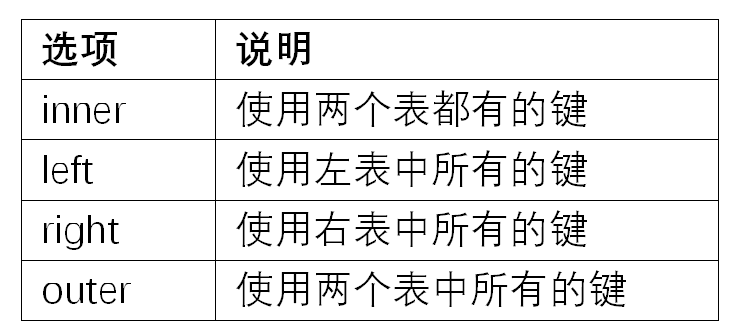